In [2]:
# https://github.com/broadinstitute/grit-benchmark
# notebook based on https://github.com/cytomining/cytominer-eval/blob/master/demos/CellPainting_Demo.ipynb

In [1]:
import os
import glob
import pandas as pd 
import numpy as np
import math

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
import plotnine as gg
from cytominer_eval import evaluate
from pycytominer.cyto_utils import infer_cp_features

os.chdir('./output')

# load data

In [2]:
# read file
df_all = pd.read_parquet("level6.parquet")

df = df_all.copy()

#------------- plates ----------------#
selected_plates = ["P103573","P103587","P103588"]
df = df[~df['Metadata_plate_map_name'].isin(selected_plates)]

# ----------- compounds ---------------#
selected_compounds = ["DMSO", "uninfected","DD4386006","DI1202001","DO8167002","[fenb]","[etop]","[stau]"]
df = df[df['Metadata_cmpdName'].isin(selected_compounds)]


# remove AB features !!!
df = df.filter(regex='^(?!.*ER)') #remove AB features

count = df["Metadata_cmpdName"].unique().tolist()
print(len(count))

# add unique pert name column
df["Metadata_pert_name"]         = df["Metadata_cmpdName"] + "_" + df["Metadata_cmpdConc"].astype("str")
df["Metadata_cmpdName_cmpdConc"] = df["Metadata_cmpdName"] + "_" + df["Metadata_cmpdConc"].astype("str")
df["num"] = df.groupby("Metadata_pert_name").cumcount() + 1
df["Metadata_pert_name"] = df["Metadata_pert_name"] + "_" + df["num"].astype("str")
df.head(5)

# infer features and metadata
features      = infer_cp_features(df)
meta_features = infer_cp_features(df, metadata=True)

8


# plot cell count

In [3]:
df_count = df[["Metadata_plate_map_name","Metadata_cmpdName","Metadata_cmpdConc", "Metadata_Well","Metadata_Object_Count"]]

mean_dmsos = df_count[df_count['Metadata_cmpdName'] == 'uninfected'].groupby('Metadata_plate_map_name')['Metadata_Object_Count'].mean()
mean_dmsos = mean_dmsos.reset_index()
mean_dmsos.columns = ['Metadata_plate_map_name', 'Mean_DMSO']


df_count = df_count.merge(mean_dmsos, on='Metadata_plate_map_name')
df_count['Normalized_Object_Count'] = df_count['Metadata_Object_Count'] / df_count['Mean_DMSO'] * 100

plate_map_names = df_count['Metadata_plate_map_name'].unique()

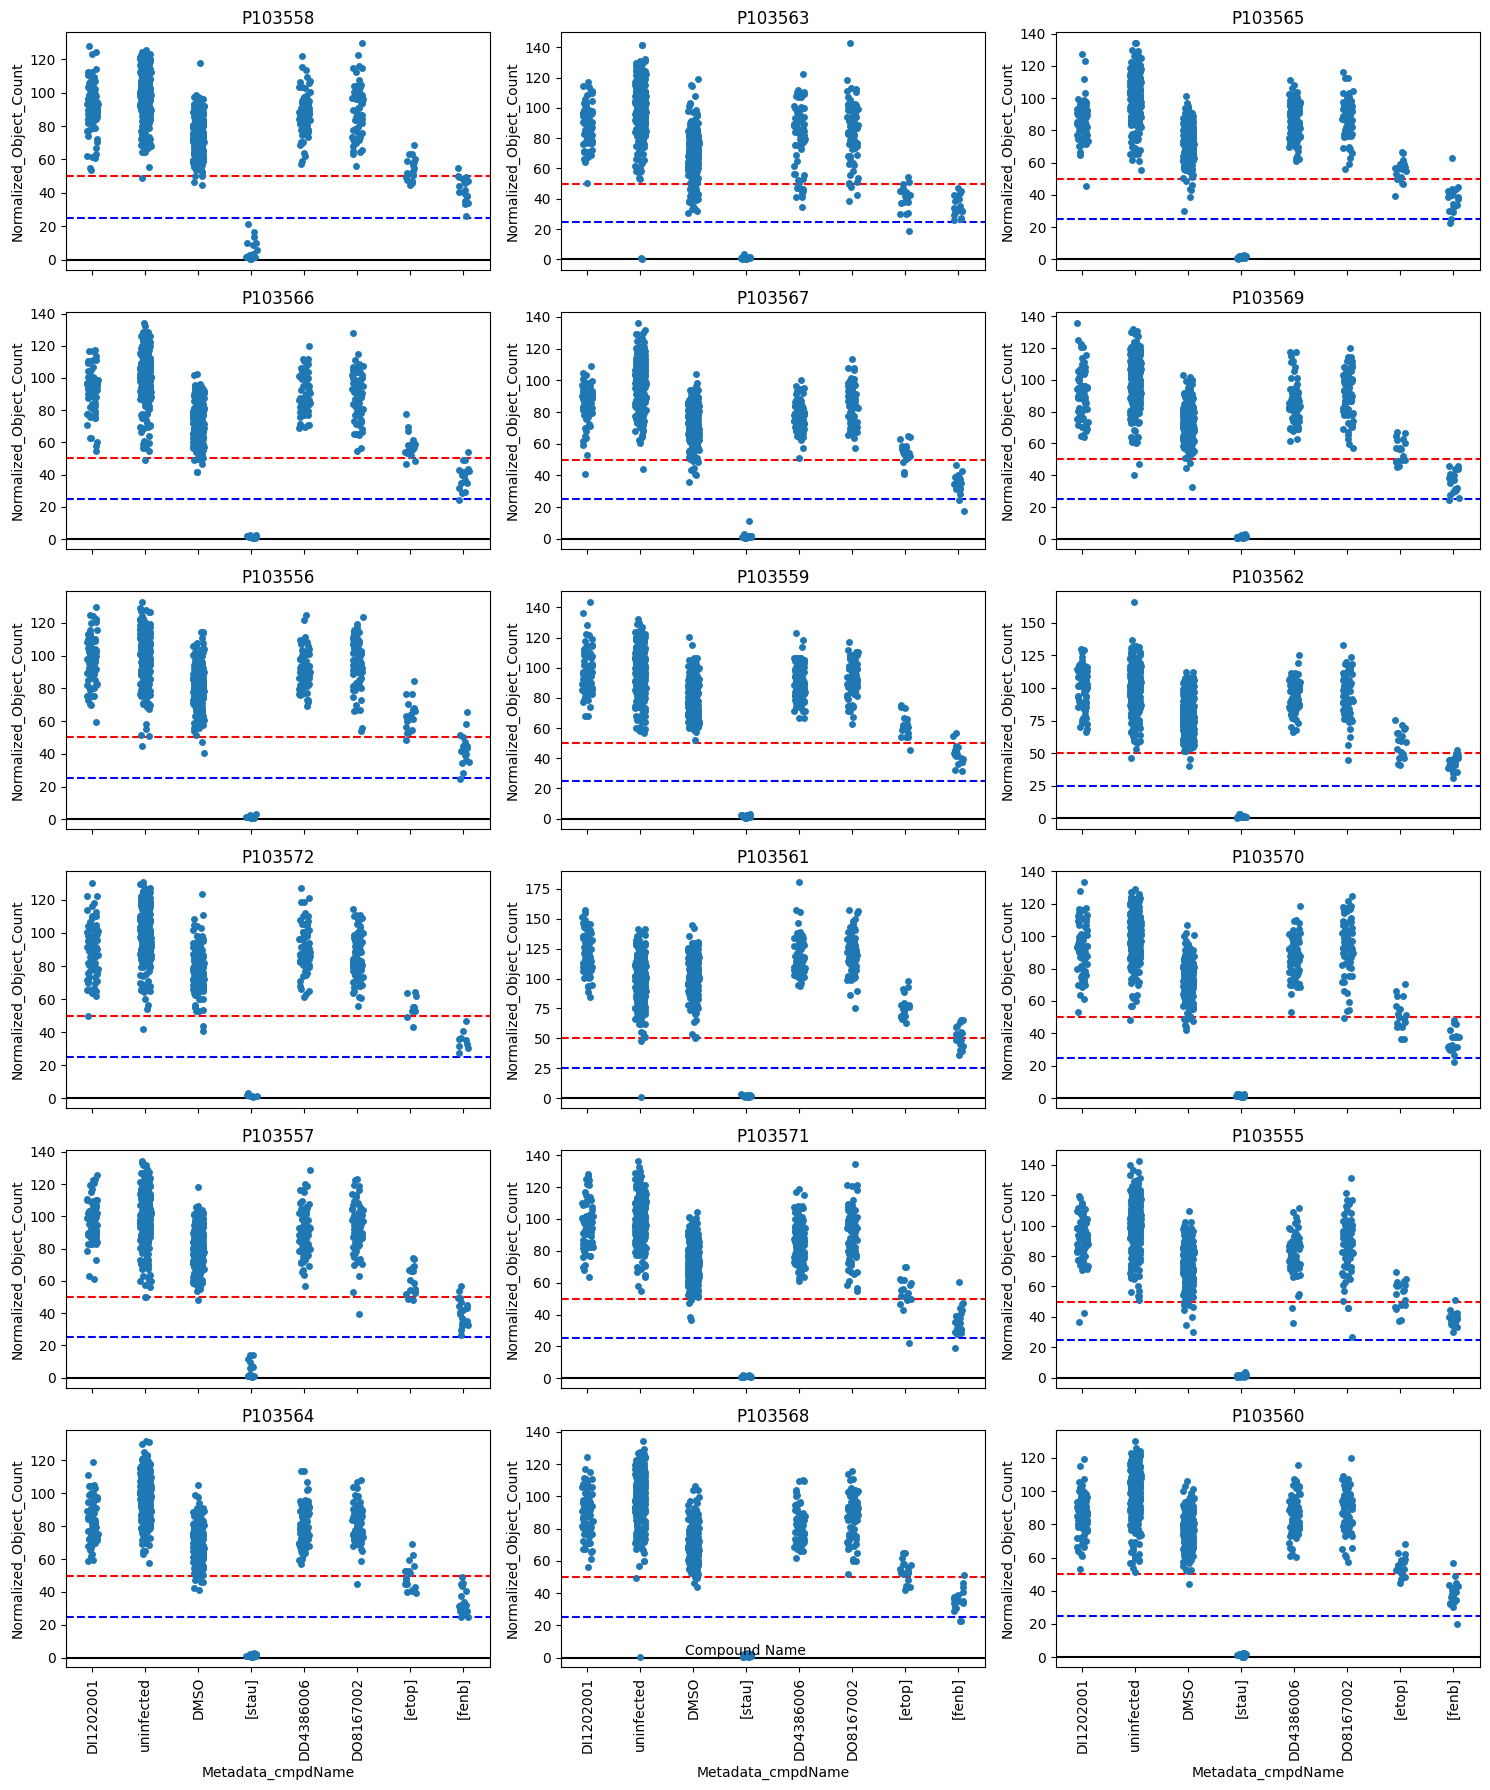

In [4]:
n_cols = 3
n_rows = math.ceil(len(plate_map_names) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows), sharex=True)

axes = axes.flatten()

for i, plate_map_name in enumerate(plate_map_names):
    data = df_count[df_count['Metadata_plate_map_name'] == plate_map_name]
    
    sns.stripplot(data=data, x='Metadata_cmpdName', y='Normalized_Object_Count', ax=axes[i])
    
    axes[i].set_title(plate_map_name)
    axes[i].tick_params(axis='x', rotation=90)
    
    axes[i].axhline(y=0, color='black', linestyle='-', label='Threshold')
    axes[i].axhline(y=25, color='blue', linestyle='--', label='Threshold')
    axes[i].axhline(y=50, color='red', linestyle='--', label='Threshold')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.text(0.5, 0.08, 'Compound Name', ha='center', va='center')

plt.tight_layout()
plt.show()

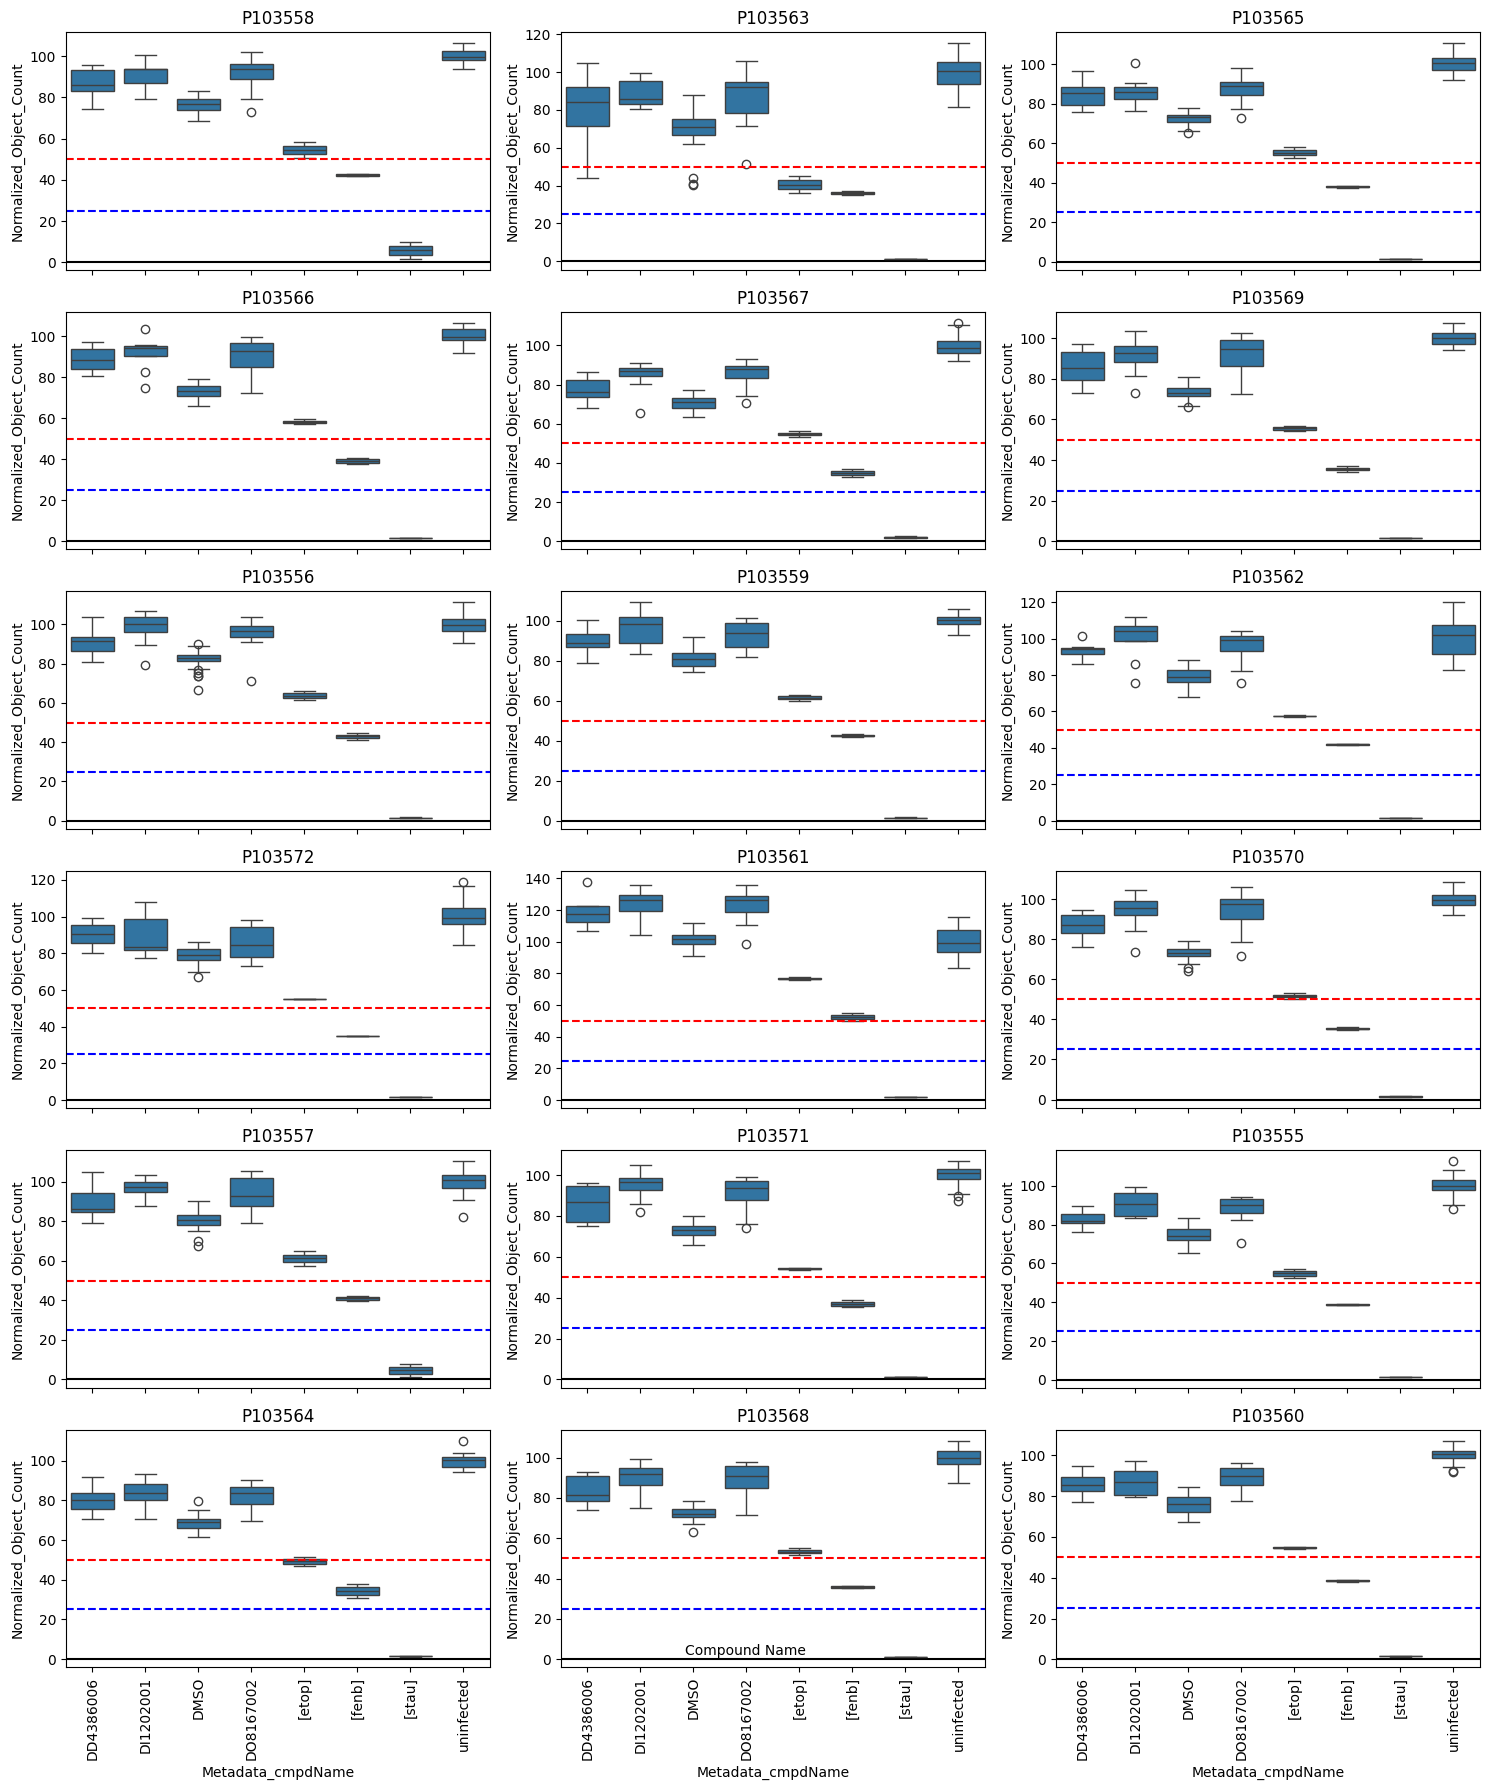

In [5]:
n_cols = 3
n_rows = math.ceil(len(plate_map_names) / n_cols)

grouped_perwell = df_count.groupby(['Metadata_plate_map_name', 'Metadata_cmpdName', 'Metadata_Well']).mean().reset_index()

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows), sharex=True)

axes = axes.flatten()

for i, plate_map_name in enumerate(plate_map_names):
    data = grouped_perwell[grouped_perwell['Metadata_plate_map_name'] == plate_map_name]
    sns.boxplot(data=data, x='Metadata_cmpdName', y='Normalized_Object_Count', ax=axes[i])
    axes[i].set_title(plate_map_name)
    axes[i].tick_params(axis='x', rotation=90)
    axes[i].axhline(y=0, color='black', linestyle='-')
    axes[i].axhline(y=25, color='blue', linestyle='--')
    axes[i].axhline(y=50, color='red', linestyle='--')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.text(0.5, 0.08, 'Compound Name', ha='center', va='center')

plt.tight_layout()
plt.show()


# replicate matching for compounds

In [63]:
# read file
df_all = pd.read_parquet("level7_modz_consensus_df_perwell.parquet")

df = df_all.copy()

#------------- plates ----------------#
selected_plates = ["P103573","P103587","P103588"]
df = df[~df['Metadata_plate_map_name'].isin(selected_plates)]

# ----------- compounds ---------------#
selected_compounds = ["DMSO", "uninfected","DD4386006","DI1202001","DO8167002","[fenb]","[etop]","[stau]"]
df = df[df['Metadata_cmpdName'].isin(selected_compounds)]


# remove AB features !!!
df = df.filter(regex='^(?!.*ER)') #remove AB features

count = df["Metadata_cmpdName"].unique().tolist()
print(len(count))

# add unique pert name column
df["Metadata_pert_name"]         = df["Metadata_cmpdName"] + "_" + df["Metadata_cmpdConc"].astype("str")
df["Metadata_cmpdName_cmpdConc"] = df["Metadata_cmpdName"] + "_" + df["Metadata_cmpdConc"].astype("str")
df["num"] = df.groupby("Metadata_pert_name").cumcount() + 1
df["Metadata_pert_name"] = df["Metadata_pert_name"] + "_" + df["num"].astype("str")
df.head(5)

# infer features and metadata
features      = infer_cp_features(df)
meta_features = infer_cp_features(df, metadata=True)

8


In [64]:
percent_matching_scores = []
pairwise_corrs = []

for plate in df.Metadata_plate_map_name.unique():
    plate_df = df.query("Metadata_plate_map_name == @plate")

    percent_matching, corr_df = evaluate(
        profiles=plate_df,
        features=features,
        meta_features=meta_features,
        replicate_groups=["Metadata_cmpdName"],
        operation="replicate_reproducibility",
        similarity_metric="pearson",
        replicate_reproducibility_quantile=0.95,
        replicate_reproducibility_return_median_cor=True,
    )
    
    percent_matching_bundle = [plate, percent_matching]
    
    percent_matching_scores.append(percent_matching_bundle)
    pairwise_corrs.append(corr_df.assign(plate=plate))


In [65]:
percent_matching_scores = pd.DataFrame(percent_matching_scores, columns=["plate", "percent_matching"])
percent_matching_scores

,plate,percent_matching
0,P103555,0.415193
1,P103556,0.332024
2,P103557,0.366080
3,P103558,0.382122
4,P103559,0.387387
5,P103560,0.323183
6,P103561,0.426639
7,P103562,0.130897
8,P103563,0.347741
9,P103564,0.449902


In [66]:
pairwise_corr_df = pd.concat(pairwise_corrs).reset_index(drop=True)

print(pairwise_corr_df.shape)
pairwise_corr_df.to_csv("level8_pairwise.csv")
pairwise_corr_df.head(10)

(141, 3)


,Metadata_cmpdName,similarity_metric,plate
0,DD4386006,0.952657,P103555
1,DI1202001,0.930180,P103555
2,DMSO,0.210794,P103555
3,DO8167002,0.942717,P103555
4,[etop],0.825206,P103555
5,[fenb],0.856967,P103555
6,[stau],0.789113,P103555
7,uninfected,0.960626,P103555
8,DD4386006,0.953101,P103556
9,DI1202001,0.936448,P103556


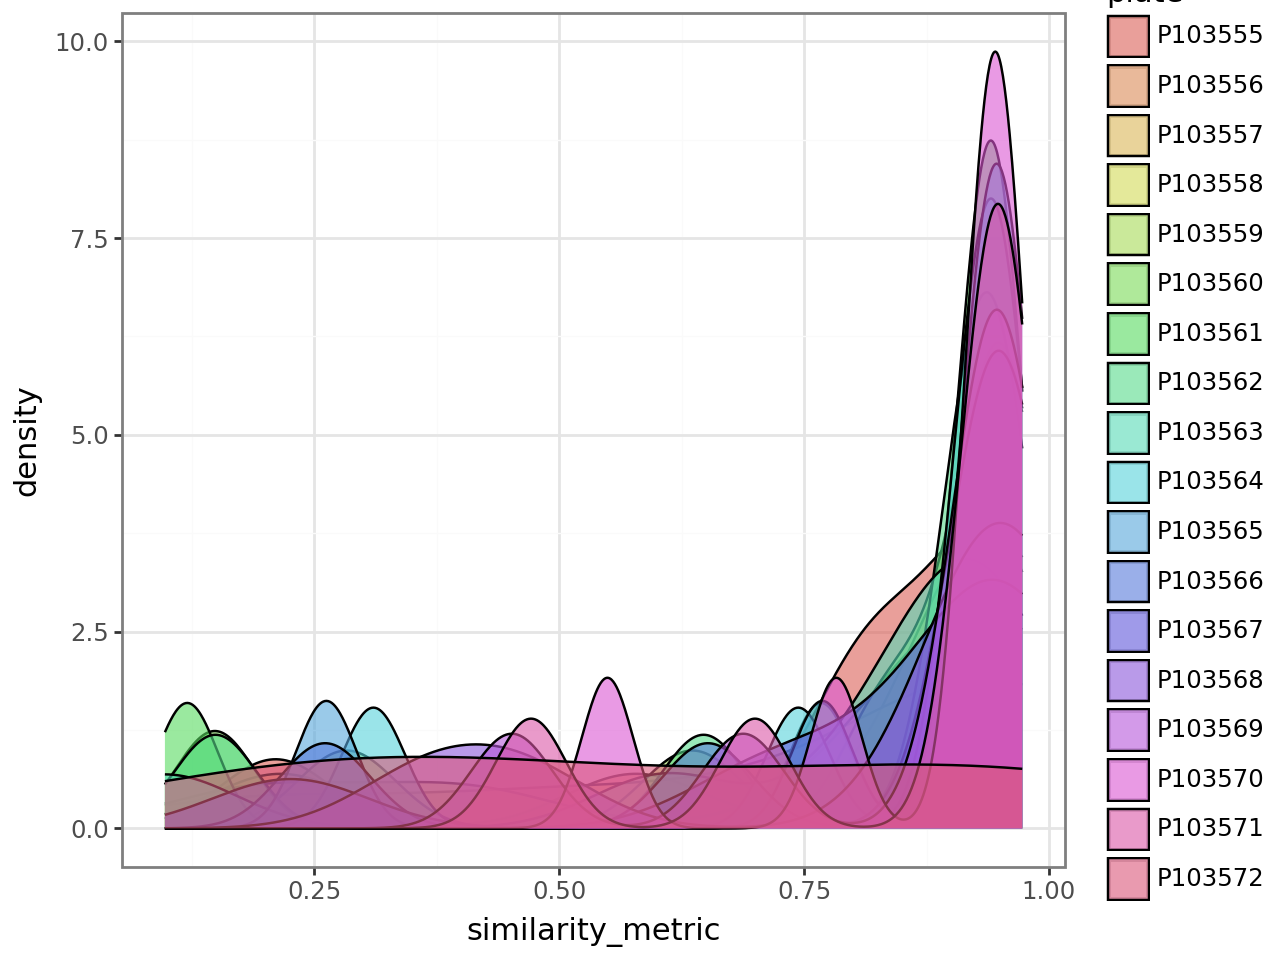

In [67]:
(
    gg.ggplot(pairwise_corr_df, gg.aes(x="similarity_metric"))
    + gg.geom_density(gg.aes(fill="plate"), alpha=0.6)
    + gg.theme_bw()
)


# Grit

In [68]:
# In grit, the variable must be a dictionary with two keys:
#        1) "profile_col"
#        2) "replicate_group_col".

#        "profile_col" - this column stores profile identifiers.
#        It can include unique entries, but it is not required.
#        cytominer_eval will calculate grit for each perturbation in the "profile_col"
#        "replicate_group_col" - this column stores replicate and group identifiers.
#        Typically one higher level "above" the profile_col, the replicate_group_col indicates how the profiles should be grouped together#

grit_scores = []

for plate_replicate in df.Metadata_plate_map_name.unique():
    plate_replicate_df = df.query("Metadata_plate_map_name == @ plate_replicate")
    
    features      = infer_cp_features(df)
    meta_features = infer_cp_features(df, metadata=True)

    control_perts = df.query("Metadata_cmpdName == 'DMSO'").Metadata_pert_name.unique().tolist()

    grit_replicate_groups = {
        "profile_col":         "Metadata_pert_name",
        "replicate_group_col": "Metadata_cmpdName"}
    
    grit_results = evaluate(
        profiles=plate_replicate_df,
        features=features,
        meta_features=meta_features,
        replicate_groups=grit_replicate_groups,
        operation="grit",
        similarity_metric="pearson",
        grit_replicate_summary_method="median",
        grit_control_perts=control_perts
    ).assign(plate=plate_replicate)

    grit_scores.append(grit_results)

grit = pd.concat(grit_scores)
grit.to_csv("level7_grit_scores_per_plate.csv")

In [69]:
grit

,perturbation,group,grit,plate
0,DD4386006_0.3_1,DD4386006,1.717095,P103555
1,DD4386006_0.3_2,DD4386006,1.620927,P103555
2,DD4386006_10.0_1,DD4386006,1.815462,P103555
3,DD4386006_10.0_2,DD4386006,1.785070,P103555
4,DD4386006_3.333333_1,DD4386006,1.764909,P103555
...,...,...,...,...
77,uninfected_0.3_572,uninfected,2.147151,P103572
78,uninfected_0.3_573,uninfected,2.217170,P103572
79,uninfected_0.3_574,uninfected,2.205207,P103572
80,uninfected_0.3_575,uninfected,2.161019,P103572


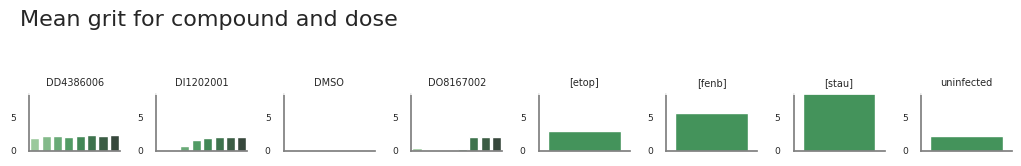

In [70]:
df = grit.copy()

df['compound'] = df['perturbation'].str.split('_').str[0]
df['dose'] = df['perturbation'].str.split('_').str[1]
df_grouped = df.groupby(['compound', 'dose'], as_index=False).agg(mean_grit=('grit', 'mean'))

fig = plt.figure(figsize=(18, 14))
sns.set(font_scale=0.6)
fig.suptitle('Mean grit for compound and dose', fontsize=16, x=0.1)
sp = 1
nrrow = 12 
nrcol = 13  

compounds_to_plot = df_grouped['compound'].unique()

for compound in compounds_to_plot:
    compound_data = df_grouped[df_grouped['compound'] == compound].copy()
    compound_data.sort_values(by='dose', inplace=True)

    ax = fig.add_subplot(nrrow, nrcol, sp)
    sns.barplot(x='dose', y='mean_grit', hue='dose', data=compound_data, palette='Greens_d', ax=ax, alpha=1,legend=False)

    ax.set_facecolor('w')
    ax.spines['bottom'].set_color('grey')
    ax.spines['left'].set_color('grey')
    ax.set_ylim([-0.1, 8.6])
    ax.set_title(f'{compound}', fontsize=7, x=0.5)
    ax.set(xlabel=None)
    ax.set(ylabel=None)
    ax.axes.xaxis.set_ticklabels([])

    sp += 1

plt.subplots_adjust(top=0.92, wspace=0.4, hspace=0.7, left=0.0)
plt.show()


# plot grit scores per compound

In [71]:
grit_percompound = grit.drop(columns=['perturbation',"plate"])
grit_percompound = grit_percompound.groupby(["group"]).mean().reset_index()

grit_perplatecompound = grit.drop(columns=['perturbation'])
grit_perplatecompound = grit_perplatecompound.groupby(["plate","group"]).mean().reset_index()

In [72]:
compounds_unsorted = grit["group"].unique()

In [73]:
grit_sub = grit.copy()
grit_sub = grit_sub.reset_index()

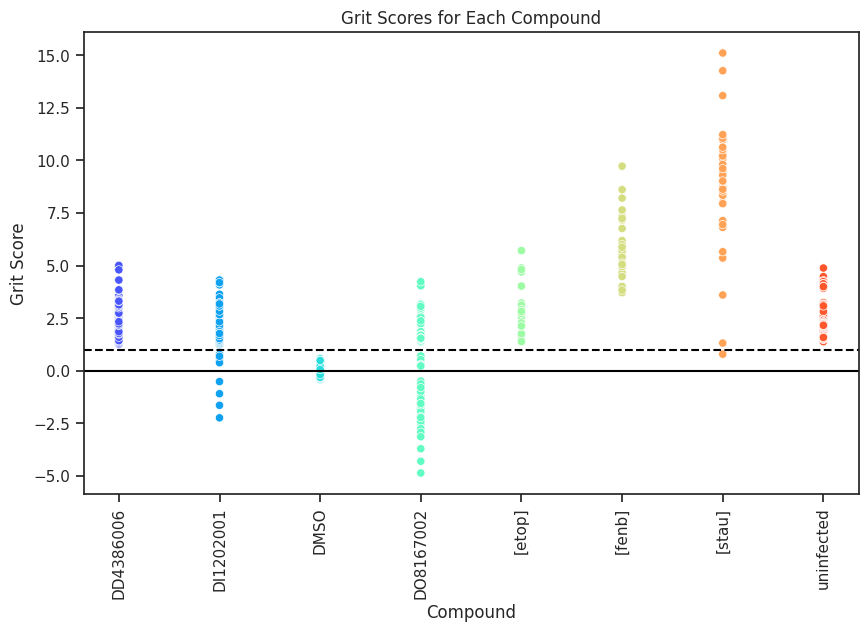

In [74]:
grouped_df        = grit_sub.groupby('group')
compound_averages = grouped_df['grit'].mean()
unique_compounds  = grit_sub['group'].unique()
color_palette     = sns.color_palette('rainbow', n_colors=len(unique_compounds))

sns.set(style="ticks")
fig, ax = plt.subplots(figsize=(10, 6)) 
sns.scatterplot(data=grit_sub, x='group',
                y='grit',
                hue='group',
                palette=color_palette,
                ax=ax,legend=False)

plt.axhline(y=0, color='black', linestyle='-', label='Threshold')
plt.axhline(y=1, color='black', linestyle='--', label='Threshold')


plt.xlabel('Compound')
plt.ylabel('Grit Score')
plt.title('Grit Scores for Each Compound')

plt.xticks(rotation=90)

plt.show()


In [75]:
mean_grit_by_group = grit_sub.groupby('group')['grit'].mean().reset_index()

groups_mean_grit_below_1 = mean_grit_by_group[mean_grit_by_group['grit'] < 1]['group'].tolist()
print("Groups with mean grit < 1:", len(groups_mean_grit_below_1), groups_mean_grit_below_1)

Groups with mean grit < 1: 1 ['DMSO']


In [76]:
mean_grit_by_group = grit_sub.groupby('group')['grit'].mean().reset_index()

groups_mean_grit_below_0_6 = mean_grit_by_group[mean_grit_by_group['grit'] < 0.6]['group'].tolist()
print("Groups with mean grit < 0.6:", len(groups_mean_grit_below_0_6), groups_mean_grit_below_0_6)

Groups with mean grit < 0.6: 1 ['DMSO']


In [77]:
mean_grit_by_group = grit_sub.groupby('group')['grit'].mean().reset_index()

groups_mean_grit_below_0_5 = mean_grit_by_group[mean_grit_by_group['grit'] < 0.5]['group'].tolist()
print("Groups with mean grit < 0.5:", len(groups_mean_grit_below_0_5), groups_mean_grit_below_0_5)

Groups with mean grit < 0.5: 1 ['DMSO']


In [78]:
mean_grit_by_group = grit_sub.groupby('group')['grit'].mean().reset_index()
groups_mean_grit_below_1 = mean_grit_by_group[mean_grit_by_group['grit'] < 1]['group'].tolist()
groups_mean_grit_below_1 = [item for item in groups_mean_grit_below_1 if item not in groups_mean_grit_below_0_5]

print("Groups with mean grit < 1:", len(groups_mean_grit_below_1), groups_mean_grit_below_1)


Groups with mean grit < 1: 0 []


In [79]:
grit_percompound

,group,grit
0,DD4386006,2.178283
1,DI1202001,1.881547
2,DMSO,0.117791
3,DO8167002,1.187240
4,[etop],2.906896
5,[fenb],5.736582
6,[stau],8.788350
7,uninfected,2.124779


_end